For a lucid and in depth explanation of the maths behind PCA 
http://www.visiondummy.com/2014/04/geometric-interpretation-covariance-matrix/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy.io import loadmat

%matplotlib notebook

<IPython.core.display.Javascript object>


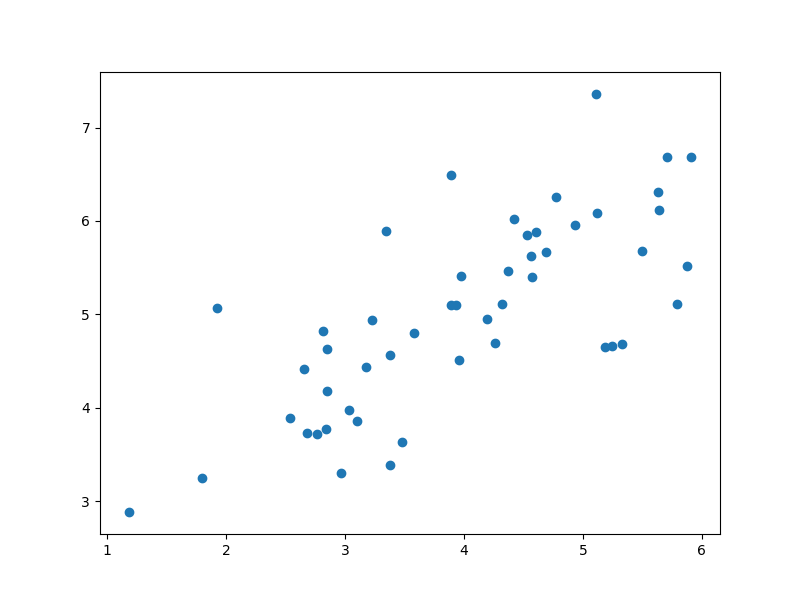

In [2]:
data = loadmat('../PCA/Data/ex7data1.mat')
data = data['X']

%matplotlib notebook
fig = plt.figure(figsize=(8, 6))
plt.scatter(data[:,0], data[:, 1])

In [3]:
'''Let's scale the data with StandardScaler transformation, which reduces mean to zero and
scale to one, necessary for PCA as it calculates the variance of features and it makes sense 
to have all features on a single scale'''
from sklearn.preprocessing import StandardScaler

def scale(data):
    '''returns fitted data along with the StandardScaler trained model for inverse transform if needed'''
    
    std = StandardScaler()
    std.fit(data)
    data_std = std.transform(data)
    
    return (data_std, std)

In [4]:
def get_cov(data_std):
    '''Get the covariance matrix of the n dimensional feature space
    A covariance matrix has variance of the features along the main diagonal and covariances on the non diagonal 
    elemnts'''

    '''Calculate the mean vector, Note: It is almost zero because of the Standard Scaler transformation 
    but we still use it to make it consistent with the formula to calculate a covariance matrix'''
    mean_vec = data_std.mean(axis=0)

    #Get the covariance matrix
    cov_mat = np.dot((data_std-mean_vec).T, (data_std-mean_vec))/(data_std.shape[0]-1)
    return cov_mat


In [5]:
def eig_decompose(cov_mat):
    '''Calculate the Eigen decomposition of the Covariance Matrix, which gives eigenvecs and eigenvals
    Covariance matrix can be interpreted as a linear operator that transforms white data into the data we observed.
    Any linear transformation can be considered as the product of a rotation matrix and a scaling matrix.
    So, eigenvecs represent this rotation and eigenvals represent the scaling'''

    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    #print('Eigenvectors \n%s' %eig_vecs)
    #print('\nEigenvalues \n%s' %eig_vals)

    '''We now have the eigenvecs and eigenvals, let's sort them on the basis of eigenvals in ascending order
    since that'll arrange eigenvecs with most variance at the top'''

    eig_pairs = [(eig_vecs[:, i], eig_vals[i]) for i in range(len(eig_vals))]
    eig_pairs = sorted(eig_pairs, key=lambda x: x[1], reverse=True)

    return eig_pairs

In [6]:
'''Now let's apply the PCA algorithm on the toy dataset given to us'''

#standardize the data
data_std, std = scale(data)
#get the covariance matrix
cov_mat = get_cov(data_std)
#get eigvec and eigvals pairs
eig_pairs = eig_decompose(cov_mat)

'''Project the data onto 1D space, by selecting the top eigen vector
We'll first create a projection matrix out of the top eigenvector'''

#projection matrix
matrix_W = eig_pairs[0][0].reshape(eig_pairs[0][0].shape[0], 1) #First element of the first tuple in the list
#And find reduced X by projecting data on matrix W
X_PCA = data_std.dot(matrix_W)

In [7]:
'''To confirm, we can recover the data with some accuracy, as a part of explained variane was lost
when we selected top eigen vector for projection'''

x_recover = X_PCA.dot(matrix_W.T)

<IPython.core.display.Javascript object>


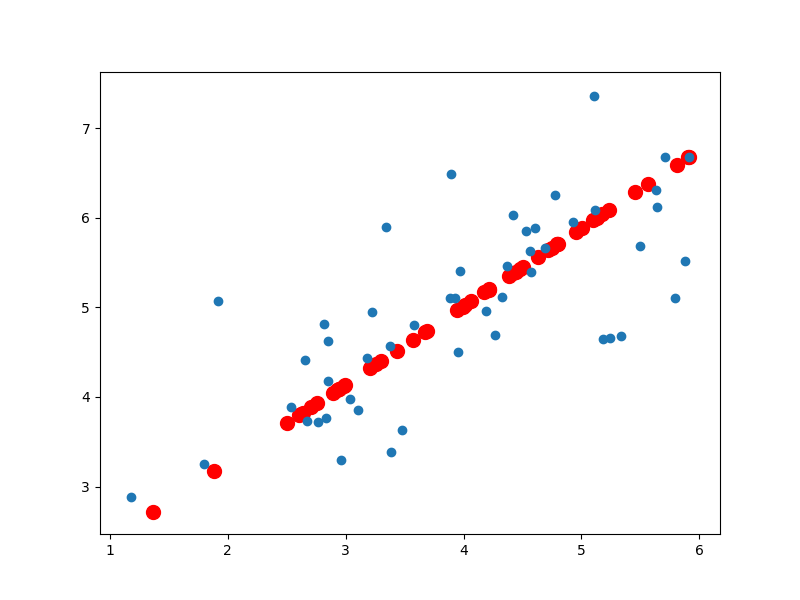

In [8]:
'''Let's visualize it'''
#First rescale the data to original size and mean
x_recover_orig = std.inverse_transform(x_recover)

#Now plot it
fig = plt.figure(figsize=(8, 6))
plt.scatter(x_recover_orig[:,0], x_recover_orig[:, 1], c='r', s=100)
plt.scatter(data[:,0], data[:, 1])

# We'll now work on the images dataset available to us and see how PCA is applied to tranform images from a thousand dimensional space to a few hundred dimensional space to speed up learning, e.g. in NNs, without losing much imformation

In [9]:
#working on faces 
faces = loadmat('../PCA/Data/ex7faces.mat')
faces = faces['X']

In [10]:
'''Visualise the faces'''
import matplotlib.cm as cm

def plot_faces(data, cols=10, rows=10):
    '''This method takes in a few sample of the images and plots in a row col format'''
    
    width, height = 32, 32 #For a 1024 dimensional space
    #initialize a canvas with (width*cols, height*rows)
    canvas = np.zeros((width*cols, height*rows))
    r, c = 0, 0
    
    #Loop over images
    for i in range(cols*rows):
        if c == cols:
            r += 1
            c = 0
        #Fill the canvas with individual images resized to height*width
        canvas[r*width:(r*width)+(width) , c*height:(c*height)+(height)] = data[i, :].reshape(height, width)
        c += 1
        
    #plot the images
    fig = plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(canvas.T, cmap=cm.Greys_r)
    

Let's visualize first 100 faces

<IPython.core.display.Javascript object>


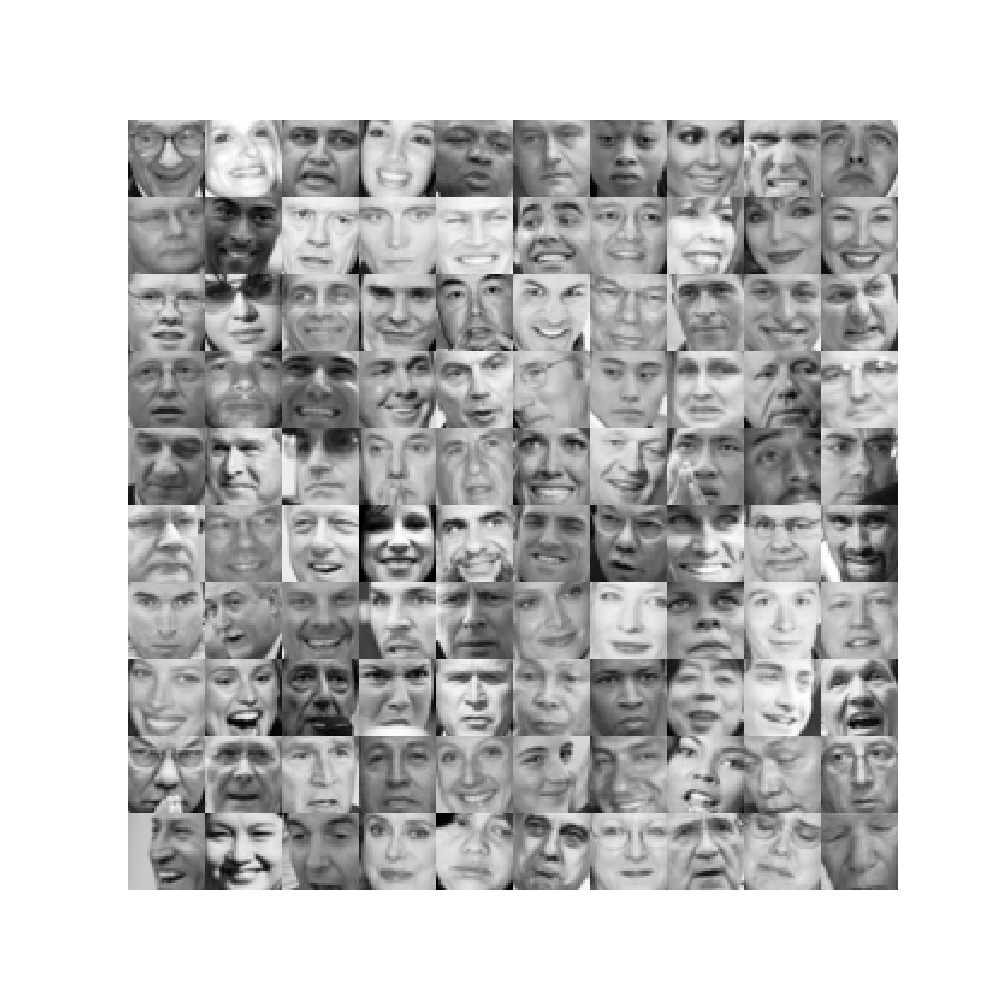

In [11]:
plot_faces(faces[:100, :])

    Apply PCA to each image and calculate the eigenvectors(1024, 1024) and eigenvalues(1, 1024)

In [12]:
faces_std, std1= scale(data=faces[:100, :])
cov_mat1 = get_cov(data_std=faces_std)
eig_pairs1 = eig_decompose(cov_mat=cov_mat1)

/Users/harshit/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


<IPython.core.display.Javascript object>


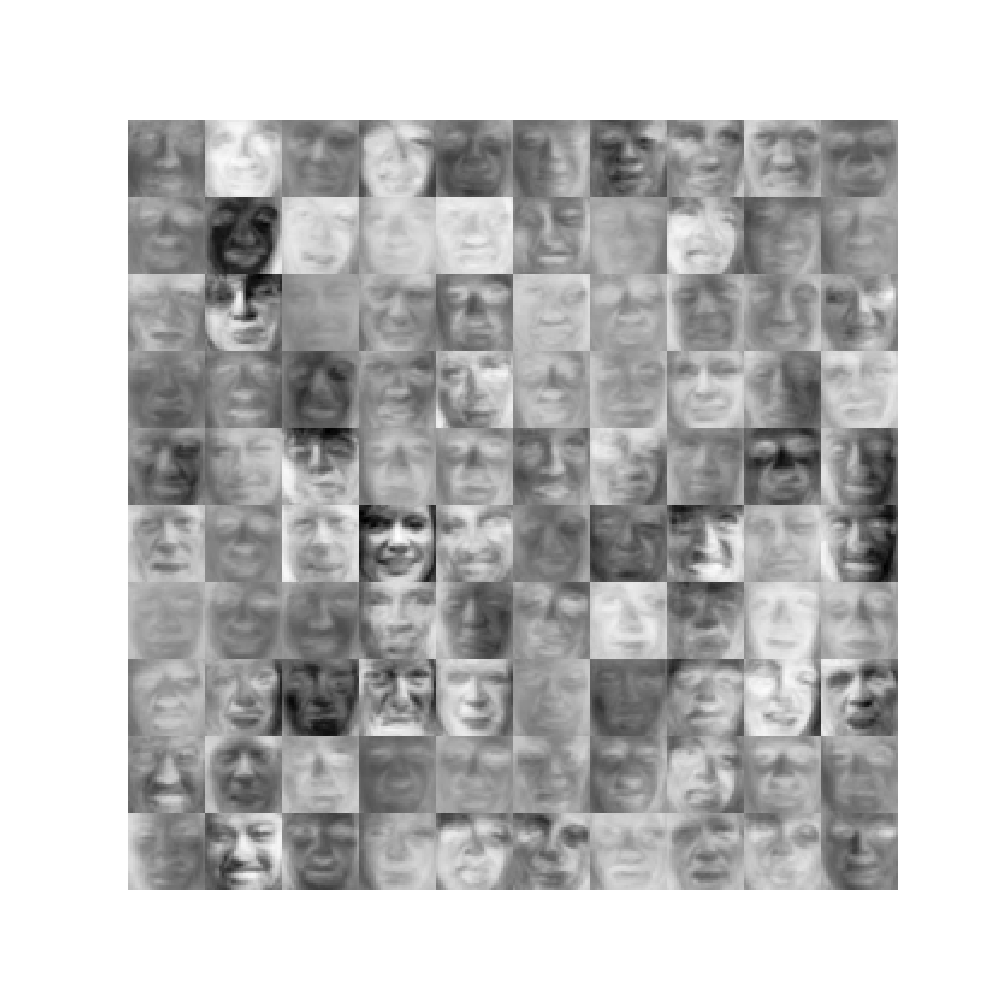

<IPython.core.display.Javascript object>


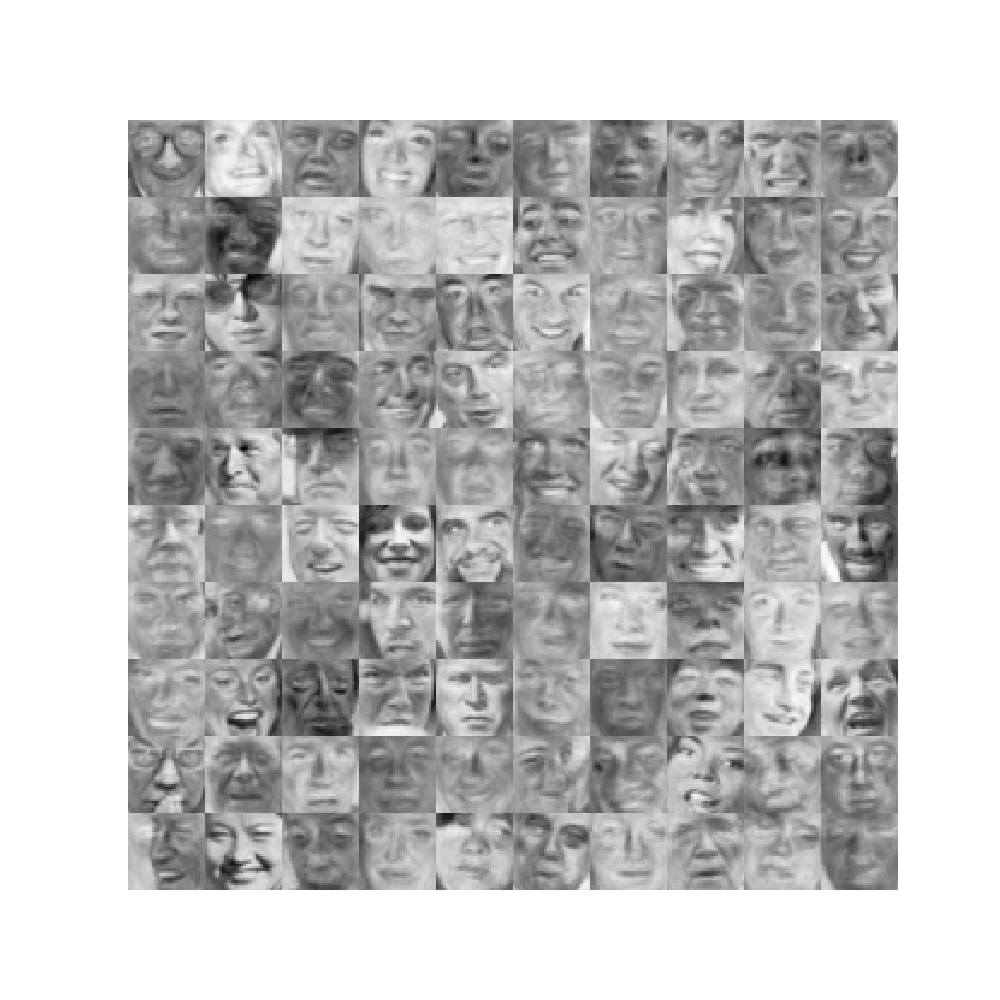

<IPython.core.display.Javascript object>


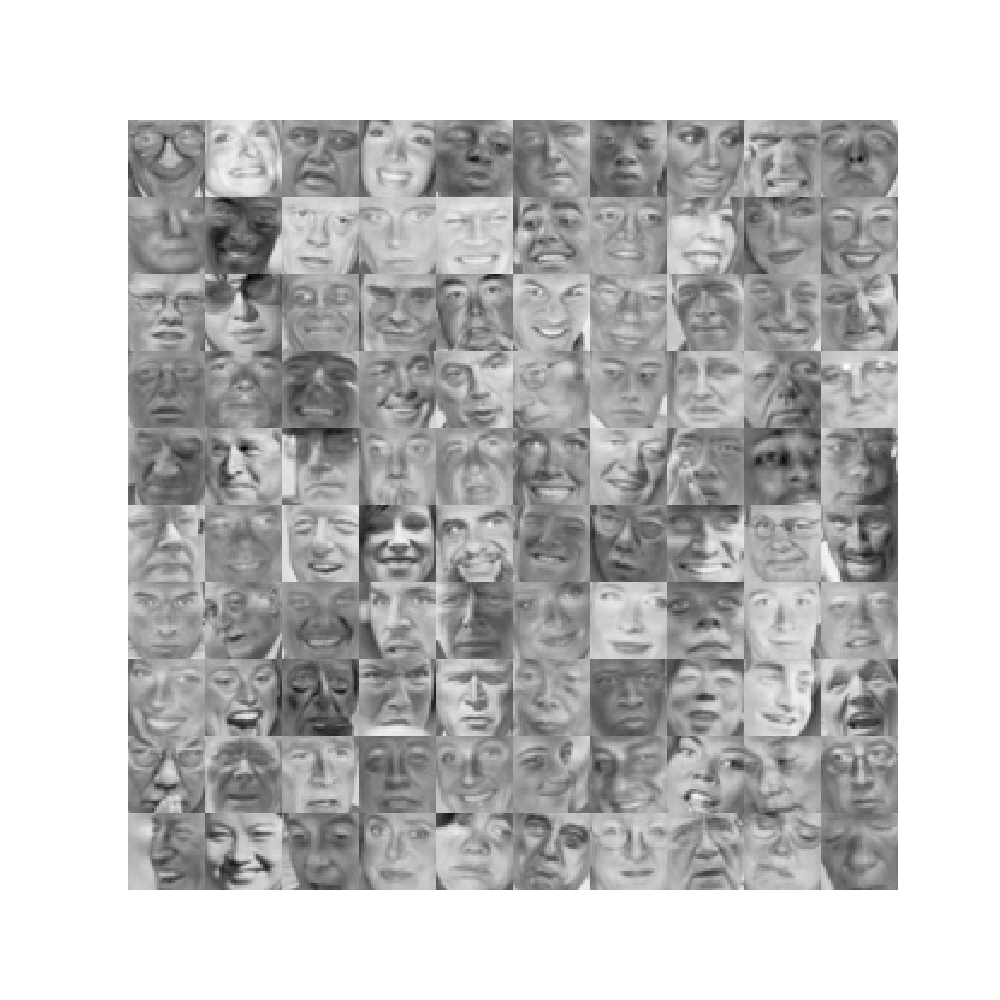

In [13]:
'''Now we'll plot all images by selecting 10, 50 and finally 100 top eigenvectors and see how much 
information is available in each dimensional space'''

for dim in ([10, 50, 100]):
    #select the top 36 eigenvectors
    matrix_W1 = np.hstack([eig_pairs1[i][0].reshape(eig_pairs1[i][0].shape[0], 1) for i in range(dim)])
    #Project it to lower 36 dimensional space
    faces_pca = faces_std.dot(matrix_W1)
    #Recover the data by projecting it back to 1024 dimensional space
    transformed_faces = faces_pca.dot(matrix_W1.T)
    plot_faces(transformed_faces, cols=10, rows=10)

# As we can see, even 50 dimensions have started to make sense and we can make out important areas in the image like eyes, nose, expressions, which can be fed to a NN for a facial recognition application